In [71]:
#About this file

#This is the historical data that covers sales from 2010-02-05 to 2012-11-01, in the file Walmart_Store_sales.
#Store - the store number
#Date - the week of sales
#Weekly_Sales - sales for the given store
#Holiday_Flag - whether the week is a special holiday week 1 – Holiday week 0 – Non-holiday week
#Temperature - Temperature on the day of sale
#Fuel_Price - Cost of fuel in the region
#CPI – Prevailing consumer price index
#Unemployment - Prevailing unemployment rate
#Holiday Events\
#Super Bowl: 12-Feb-10, 11-Feb-11, 10-Feb-12, \
#Labour Day: 10-Sep-10, 9-Sep-11, 7-Sep-12, \
#Thanksgiving: 26-Nov-10, 25-Nov-11, 23-Nov-12,\
#Christmas: 31-Dec-10, 30-Dec-11, 28-Dec-12,
#Store,This file contains anonymized information about the 45 stores, indicating the type and size of store.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
import seaborn as sb

!pip install pycaret --quiet
from pycaret.regression import *
from pycaret.regression import setup, compare_models

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.ensemble import RandomForestRegressor

import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

In [73]:
#Data Preprocessing
#Importing the datasets
stores=pd.read_csv('/kaggle/input/walmart-recruiting-store-sales-forecasting/stores.csv')
data=pd.read_csv("/kaggle/input/walmart-dataset/Walmart.csv")
df=data.merge(stores,how='inner',on='Store')
df.head(10)

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Type,Size
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106,A,151315
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106,A,151315
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106,A,151315
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106,A,151315
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106,A,151315
5,1,12-03-2010,1439541.59,0,57.79,2.667,211.380643,8.106,A,151315
6,1,19-03-2010,1472515.79,0,54.58,2.720,211.215635,8.106,A,151315
7,1,26-03-2010,1404429.92,0,51.45,2.732,211.018042,8.106,A,151315
8,1,02-04-2010,1594968.28,0,62.27,2.719,210.820450,7.808,A,151315
9,1,09-04-2010,1545418.53,0,65.86,2.770,210.622857,7.808,A,151315


In [74]:
#Sperate Date
df['Date'] = pd.to_datetime(df['Date'])
df['Week'] = df['Date'].dt.isocalendar().week.astype('int64')
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year

In [75]:
#Creating New Column
conditions = [
    
    df['Date'].isin(pd.to_datetime(['12-02-2010', '11-02-2011', '10-02-2012'])),
    df['Date'].isin(pd.to_datetime(['10-09-2010', '09-09-2011', '07-09-2012'])),
    df['Date'].isin(pd.to_datetime(['26-11-2010', '25-11-2011', '23-11-2012'])),
    df['Date'].isin(pd.to_datetime(['31-12-2010', '30-12-2011', '28-12-2012']))
]

values = [
    'SuperBowl',
    'LabourDay',
    'Thanksgiving',
    'Christmas'
]

df['SpecialDays'] = np.select(conditions, values, default='Normal')
df.head(10)

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Type,Size,Week,Month,Year,SpecialDays
0,1,2010-05-02,1643690.90,0,42.31,2.572,211.096358,8.106,A,151315,17,5,2010,Normal
1,1,2010-12-02,1641957.44,1,38.51,2.548,211.242170,8.106,A,151315,48,12,2010,SuperBowl
2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106,A,151315,7,2,2010,Normal
3,1,2010-02-26,1409727.59,0,46.63,2.561,211.319643,8.106,A,151315,8,2,2010,Normal
4,1,2010-05-03,1554806.68,0,46.50,2.625,211.350143,8.106,A,151315,18,5,2010,Normal
5,1,2010-12-03,1439541.59,0,57.79,2.667,211.380643,8.106,A,151315,48,12,2010,Normal
6,1,2010-03-19,1472515.79,0,54.58,2.720,211.215635,8.106,A,151315,11,3,2010,Normal
7,1,2010-03-26,1404429.92,0,51.45,2.732,211.018042,8.106,A,151315,12,3,2010,Normal
8,1,2010-02-04,1594968.28,0,62.27,2.719,210.820450,7.808,A,151315,5,2,2010,Normal
9,1,2010-09-04,1545418.53,0,65.86,2.770,210.622857,7.808,A,151315,35,9,2010,Normal


In [76]:
print('\n\033[1mInference:\033[0m The Datset consists of '+ str(df.shape[0]) +' features & '+ str(df.shape[1]) +' samples.')


Inference: The Datset consists of 6435 features & 14 samples.


In [77]:
#Checking data
df.nunique()


Store             45
Date             143
Weekly_Sales    6435
Holiday_Flag       2
Temperature     3528
Fuel_Price       892
CPI             2145
Unemployment     349
Type               3
Size              40
Week              52
Month             12
Year               3
SpecialDays        5
dtype: int64

In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6435 entries, 0 to 6434
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Store         6435 non-null   int64         
 1   Date          6435 non-null   datetime64[ns]
 2   Weekly_Sales  6435 non-null   float64       
 3   Holiday_Flag  6435 non-null   int64         
 4   Temperature   6435 non-null   float64       
 5   Fuel_Price    6435 non-null   float64       
 6   CPI           6435 non-null   float64       
 7   Unemployment  6435 non-null   float64       
 8   Type          6435 non-null   object        
 9   Size          6435 non-null   int64         
 10  Week          6435 non-null   int64         
 11  Month         6435 non-null   int64         
 12  Year          6435 non-null   int64         
 13  SpecialDays   6435 non-null   object        
dtypes: datetime64[ns](1), float64(5), int64(6), object(2)
memory usage: 754.1+ KB


In [79]:
df.isna().sum()

Store           0
Date            0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
Type            0
Size            0
Week            0
Month           0
Year            0
SpecialDays     0
dtype: int64

In [80]:
df.describe()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Size,Week,Month,Year
count,6435.000000,6.435000e+03,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000
mean,23.000000,1.046965e+06,0.069930,60.663782,3.358607,171.578394,7.999151,130287.600000,26.000000,6.475524,2010.965035
std,12.988182,5.643666e+05,0.255049,18.444933,0.459020,39.356712,1.875885,63117.022465,14.511794,3.321797,0.797019
min,1.000000,2.099862e+05,0.000000,-2.060000,2.472000,126.064000,3.879000,34875.000000,1.000000,1.000000,2010.000000
25%,12.000000,5.533501e+05,0.000000,47.460000,2.933000,131.735000,6.891000,70713.000000,14.000000,4.000000,2010.000000
50%,23.000000,9.607460e+05,0.000000,62.670000,3.445000,182.616521,7.874000,126512.000000,26.000000,6.000000,2011.000000
75%,34.000000,1.420159e+06,0.000000,74.940000,3.735000,212.743293,8.622000,202307.000000,38.000000,9.000000,2012.000000
max,45.000000,3.818686e+06,1.000000,100.140000,4.468000,227.232807,14.313000,219622.000000,52.000000,12.000000,2012.000000


In [81]:
df[df['Weekly_Sales']<=0]

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Type,Size,Week,Month,Year,SpecialDays


  Type  Store      Size
0    A     22  177248.0
1    B     17  101191.0
2    C      6   40542.0


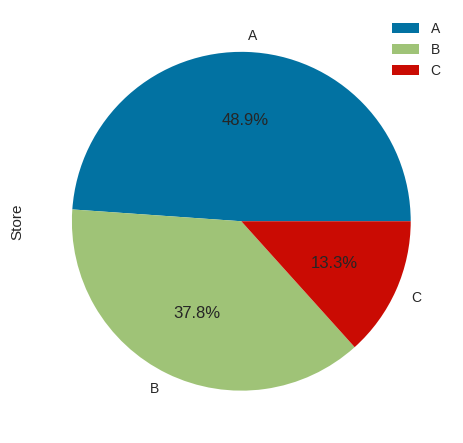

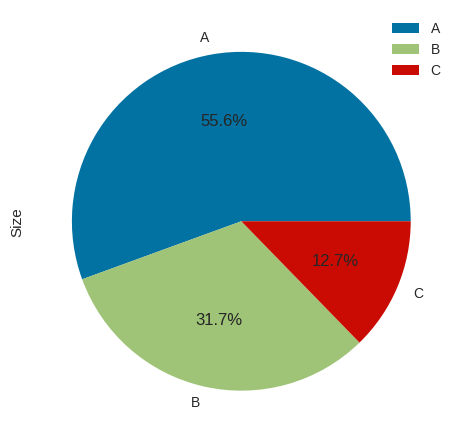

In [82]:
#Explore the data
#Store Count Pie Chart
storecount = df.groupby('Type').agg({'Store': 'nunique', 'Size': 'mean'}).reset_index().round()
print(storecount)
storecount.plot(kind='pie', y='Store', labels=storecount['Type'], autopct='%1.1f%%')
storecount.plot(kind='pie', y='Size', labels=storecount['Type'], autopct='%1.1f%%')
plt.show()

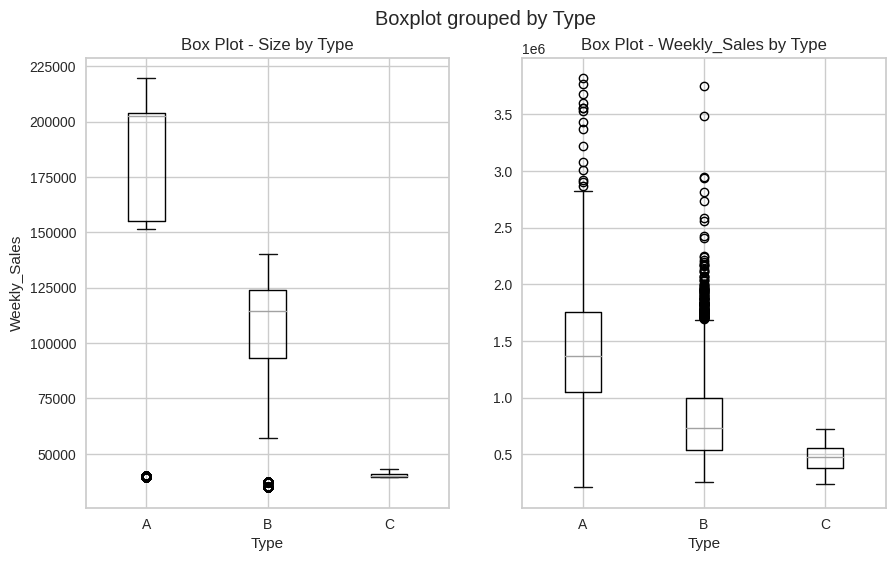

In [83]:
#Store Type BoxPlot
fig, axes = plt.subplots(1, 2, figsize=(10, 6))
df.boxplot(column='Size',by='Type',ax=axes[0])
axes[0].set_title('Box Plot - Size by Type')
axes[0].set_xlabel('Type')
axes[0].set_ylabel('Size')
df.boxplot(column='Weekly_Sales',by='Type',ax=axes[1])
axes[1].set_title('Box Plot - Weekly_Sales by Type')
axes[1].set_xlabel('Type')
axes[0].set_ylabel('Weekly_Sales')
plt.show()

In [84]:
#Reviewing Store Sales-Pivot_Table
store_year = pd.pivot_table(df[df['Week'] <= 43], values = "Weekly_Sales", columns = "Year", index = "Store",aggfunc=sum)
store_year.round(0).head(10)

Year,2010,2011,2012
Store,,,
1,58074579.0,65377394.0,65017889.0
2,74796146.0,78778941.0,77678429.0
3,14773897.0,16765169.0,17181650.0
4,74778508.0,88852389.0,88510502.0
5,11710703.0,13260777.0,13509622.0
6,60498039.0,64474563.0,63338574.0
7,19748553.0,24232312.0,24403695.0
8,33869854.0,38271181.0,37386279.0
9,19732579.0,22980209.0,22822992.0


In [85]:
df.groupby(['Year', 'Month'])['Week'].unique()

Year  Month
2010  1                         [1]
      2                   [7, 8, 5]
      3                [11, 12, 10]
      4            [15, 16, 17, 14]
      5        [17, 18, 19, 20, 21]
      6                [24, 25, 23]
      7            [27, 28, 29, 30]
      8                [32, 33, 34]
      9            [35, 36, 37, 38]
      10           [40, 41, 42, 43]
      11               [44, 46, 47]
      12       [48, 49, 50, 51, 52]
2011  1                [2, 3, 4, 1]
      2                   [7, 8, 6]
      3                 [11, 12, 9]
      4            [13, 15, 16, 17]
      5            [19, 20, 21, 18]
      6                [22, 24, 25]
      7        [26, 28, 29, 30, 27]
      8                [31, 33, 34]
      9            [36, 37, 38, 39]
      10           [40, 41, 42, 43]
      11           [44, 45, 46, 47]
      12           [49, 50, 51, 52]
2012  1                [2, 3, 4, 1]
      2                   [7, 8, 5]
      3         [9, 11, 12, 13, 10]
      4         

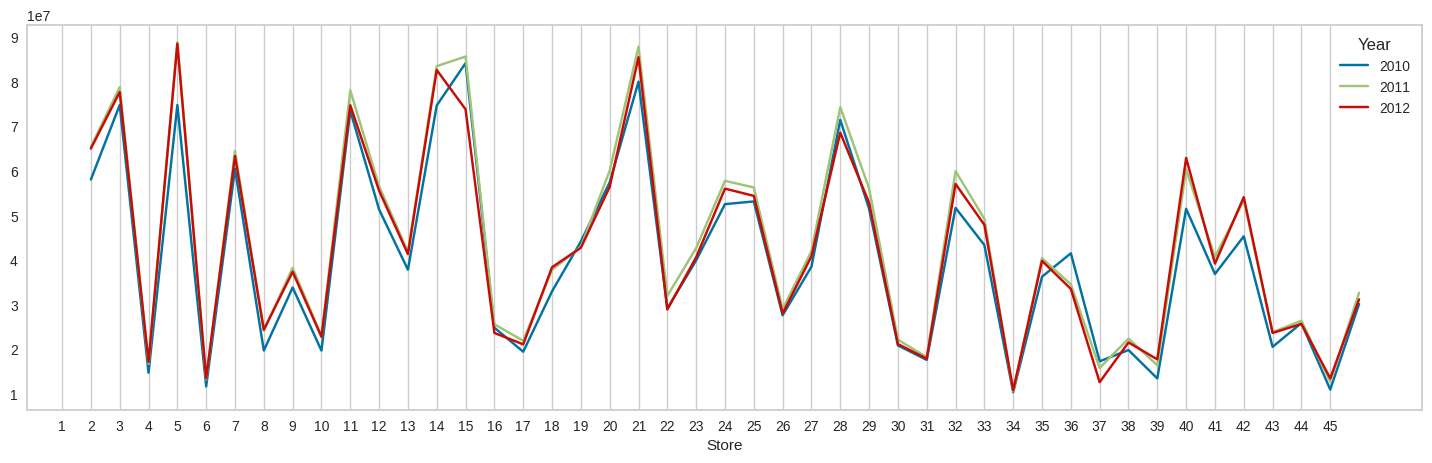

In [86]:
store_year.plot(figsize=(18, 5))
plt.xticks(range(len(store_year.index)), store_year.index)
plt.grid( axis='y')
plt.show()

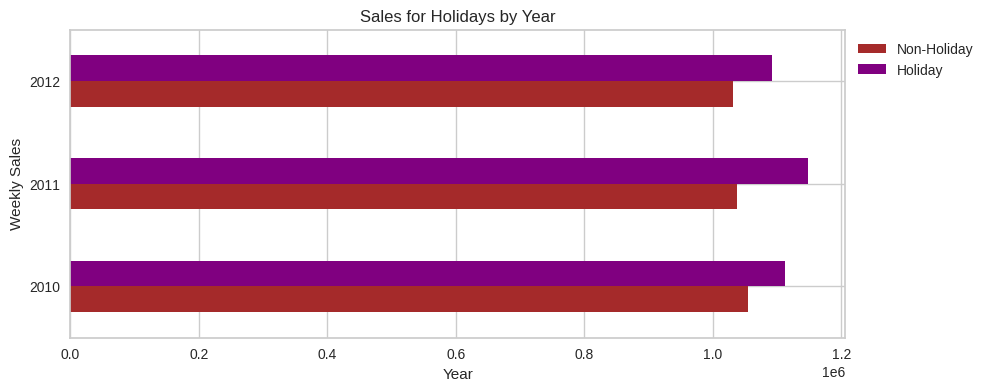

In [87]:
#Reviewing Holidays
yearly_holiday_sales = df.groupby([ 'Year','Holiday_Flag',])['Weekly_Sales'].mean().round().unstack()
yearly_holiday_sales.plot(kind='barh', color=['brown', 'purple','green'], figsize=(10, 4))
plt.xlabel('Year')
plt.ylabel('Weekly Sales')
plt.title("Sales for Holidays by Year")
plt.legend(['Non-Holiday', 'Holiday'],bbox_to_anchor=(1,1))
plt.show()

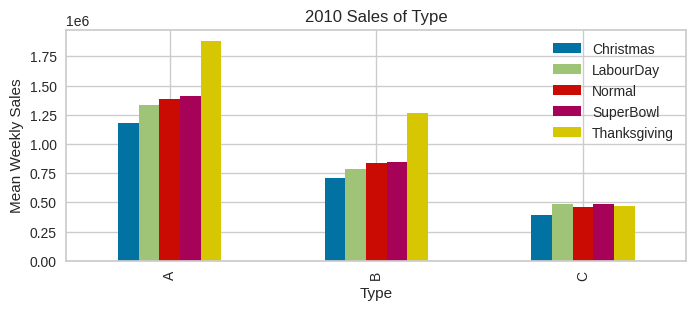

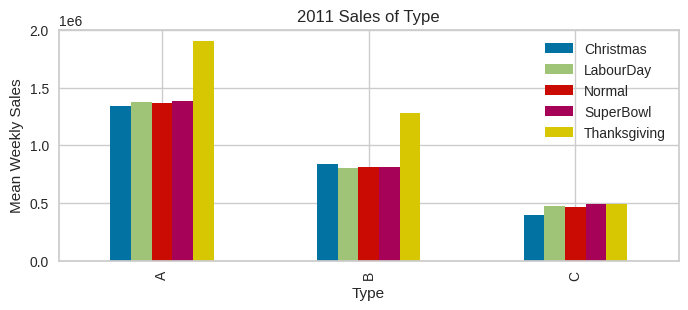

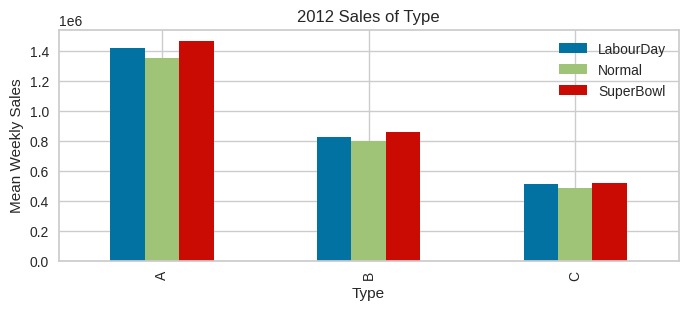

In [88]:
grouped_data=df[df['Year'] == 2010].groupby(['Type','SpecialDays'])['Weekly_Sales'].mean().round()
fig, ax = plt.subplots(figsize=(8, 3)) 
grouped_data.unstack().plot(kind='bar', ax=ax)

ax.set_xlabel('Type')
ax.set_ylabel('Mean Weekly Sales')
ax.set_title("2010 Sales of Type")
plt.legend(fontsize='small')

grouped_data=df[df['Year'] == 2011].groupby(['Type','SpecialDays'])['Weekly_Sales'].mean().round()
fig, ax = plt.subplots(figsize=(8, 3))
grouped_data.unstack().plot(kind='bar', ax=ax)

ax.set_xlabel('Type')
ax.set_ylabel('Mean Weekly Sales')
ax.set_title("2011 Sales of Type")
plt.legend(fontsize='small')

grouped_data=df[df['Year'] == 2012].groupby(['Type','SpecialDays'])['Weekly_Sales'].mean().round()
fig, ax = plt.subplots(figsize=(8, 3))
grouped_data.unstack().plot(kind='bar', ax=ax)

ax.set_xlabel('Type')
ax.set_ylabel('Mean Weekly Sales')
ax.set_title("2012 Sales of Type")
plt.legend(fontsize='small')
plt.show()

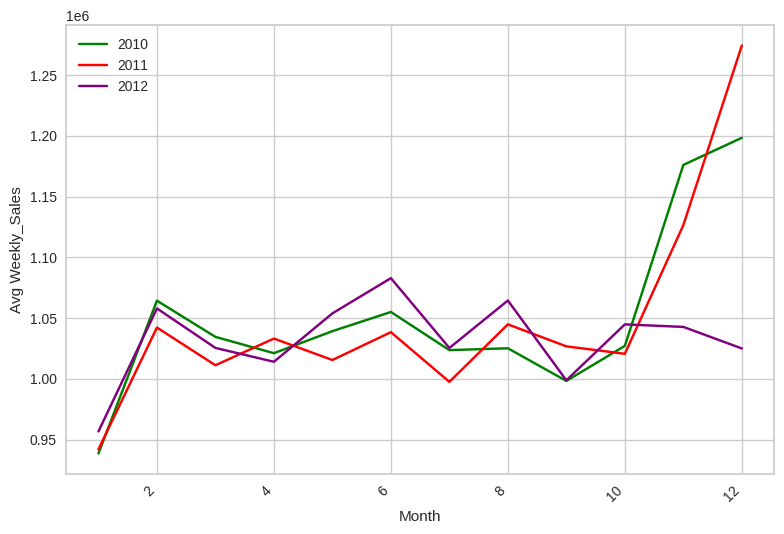

In [89]:
#Reviewing Sales
fig = plt.figsize=(10, 4)

plt.plot(df[df['Year'] == 2010].groupby(['Month'])['Weekly_Sales'].mean().round(),color='Green',label='2010')
plt.plot(df[df['Year'] == 2011].groupby(['Month'])['Weekly_Sales'].mean().round(),color='Red',label='2011')
plt.plot(df[df['Year'] == 2012].groupby(['Month'])['Weekly_Sales'].mean().round(),color='Purple',label='2012')

plt.xlabel('Month')
plt.ylabel('Avg Weekly_Sales')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.legend()
plt.show()

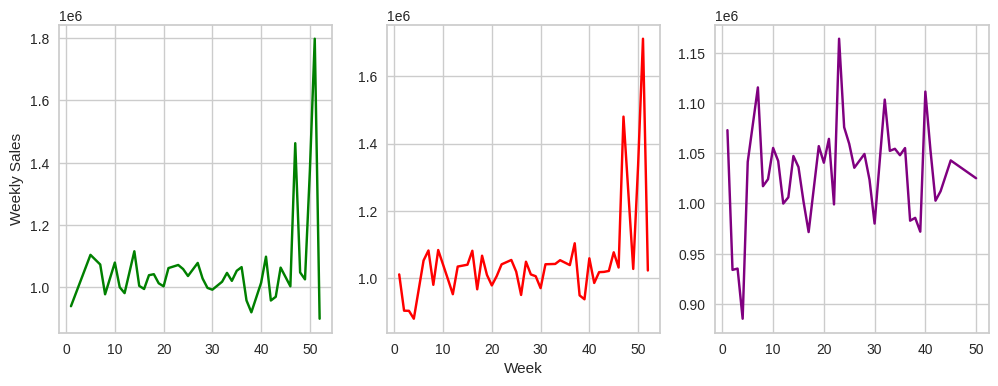

In [90]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

axs[0].plot(df[df['Year'] == 2010].groupby(['Week'])['Weekly_Sales'].mean().round(), color='Green', label='2010')
axs[1].plot(df[df['Year'] == 2011].groupby(['Week'])['Weekly_Sales'].mean().round(), color='Red', label='2011')
axs[2].plot(df[df['Year'] == 2012].groupby(['Week'])['Weekly_Sales'].mean().round(), color='Purple', label='2012')


axs[0].set_ylabel('Weekly Sales')
axs[1].set_xlabel('Week')


plt.show()


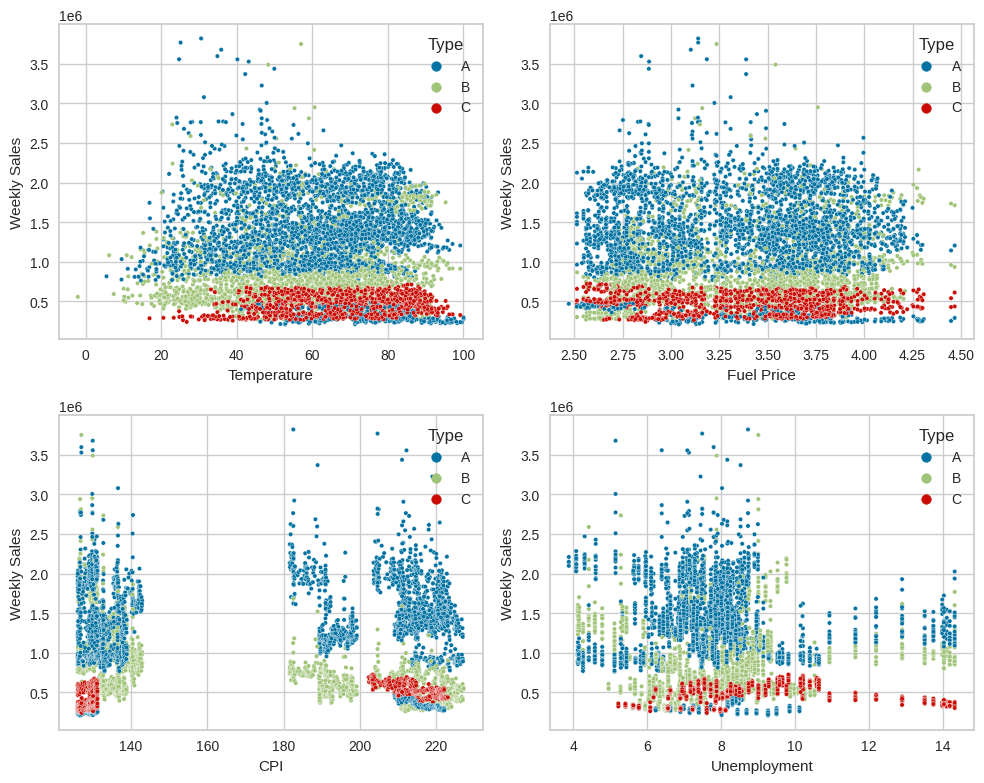

In [91]:
#Features Relations
#Seaborn Scatter Plot 
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

sb.scatterplot(x=df['Temperature'], y=df['Weekly_Sales'], hue=df['Type'], ax=axs[0, 0], s=10)
sb.scatterplot(x=df['Fuel_Price'], y=df['Weekly_Sales'], hue=df['Type'], ax=axs[0, 1], s=10)
sb.scatterplot(x=df['CPI'], y=df['Weekly_Sales'], hue=df['Type'], ax=axs[1, 0], s=10)
sb.scatterplot(x=df['Unemployment'], y=df['Weekly_Sales'], hue=df['Type'], ax=axs[1, 1], s=10)

axs[0, 0].set_xlabel('Temperature')
axs[0, 0].set_ylabel('Weekly Sales')

axs[0, 1].set_xlabel('Fuel Price')
axs[0, 1].set_ylabel('Weekly Sales')

axs[1, 0].set_xlabel('CPI')
axs[1, 0].set_ylabel('Weekly Sales')

axs[1, 1].set_xlabel('Unemployment')
axs[1, 1].set_ylabel('Weekly Sales')

plt.tight_layout()
plt.show()

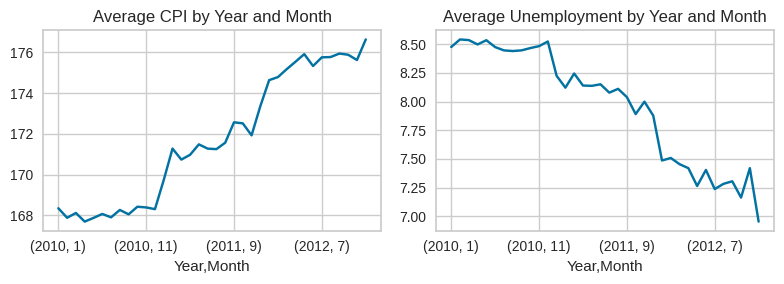

In [92]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 3))

df.groupby(['Year', 'Month'])['CPI'].mean().plot(ax=axes[0])
df.groupby(['Year', 'Month'])['Unemployment'].mean().plot(ax=axes[1])

axes[0].set_title('Average CPI by Year and Month')

axes[1].set_title('Average Unemployment by Year and Month')

plt.tight_layout()
plt.show()

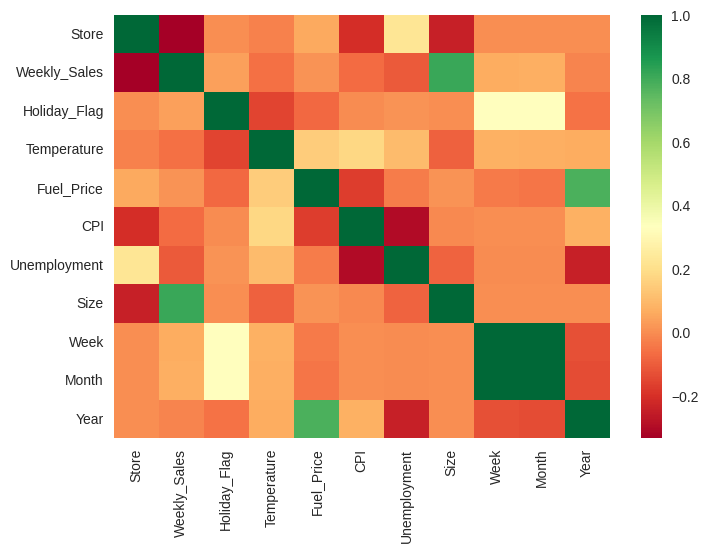

In [93]:
#HeatMap
sb.heatmap(df.corr(),cmap='RdYlGn')
plt.show()

In [94]:
#ML 
feature=df[['Store','Holiday_Flag','Temperature','Fuel_Price','Week','Month','Year']]
feature

,Store,Holiday_Flag,Temperature,Fuel_Price,Week,Month,Year
0,1,0,42.31,2.572,17,5,2010
1,1,1,38.51,2.548,48,12,2010
2,1,0,39.93,2.514,7,2,2010
3,1,0,46.63,2.561,8,2,2010
4,1,0,46.50,2.625,18,5,2010
...,...,...,...,...,...,...,...
6430,45,0,64.88,3.997,39,9,2012
6431,45,0,64.89,3.985,19,5,2012
6432,45,0,54.47,4.000,50,12,2012
6433,45,0,56.47,3.969,42,10,2012


In [95]:
target=df[['Weekly_Sales']]
target

,Weekly_Sales
0,1643690.90
1,1641957.44
2,1611968.17
3,1409727.59
4,1554806.68
...,...
6430,713173.95
6431,733455.07
6432,734464.36
6433,718125.53


In [96]:
#PyCaret Control
feature1=df[['Store','Holiday_Flag','Temperature','Fuel_Price','Week','Month','Year','Weekly_Sales']]

In [97]:
pycare = setup(feature1, target = 'Weekly_Sales',train_size=0.8)

,Description,Value
0,Session id,298
1,Target,Weekly_Sales
2,Target type,Regression
3,Original data shape,"(6435, 8)"
4,Transformed data shape,"(6435, 8)"
5,Transformed train set shape,"(5148, 8)"
6,Transformed test set shape,"(1287, 8)"
7,Numeric features,7
8,Preprocess,True
9,Imputation type,simple


In [98]:
best_model = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,60985.2751,9298916897.3114,96068.3681,0.9713,0.0977,0.0675,2.5090
xgboost,Extreme Gradient Boosting,58546.0531,9354983372.8000,96041.2031,0.9712,0.1035,0.0629,0.2510
lightgbm,Light Gradient Boosting Machine,63790.8596,10878940605.1877,103726.6245,0.9665,0.1029,0.0688,0.4240
et,Extra Trees Regressor,75895.5077,17862082190.0003,132928.6117,0.9450,0.1150,0.0774,0.5620
rf,Random Forest Regressor,74609.4785,19001915131.0640,137453.1185,0.9411,0.1011,0.0683,0.8400
dt,Decision Tree Regressor,92917.9903,30111156478.5851,172915.0878,0.9067,0.1257,0.0844,0.0440
gbr,Gradient Boosting Regressor,144064.8627,37280981639.6091,192732.3069,0.8846,0.2250,0.1869,0.3090
ada,AdaBoost Regressor,415577.6464,239313496562.2680,489141.6412,0.2563,0.5576,0.6234,0.1990
knn,K Neighbors Regressor,395978.1625,263359125913.6000,512968.6531,0.1823,0.5371,0.5259,0.0400
lr,Linear Regression,438992.8175,283497493282.6354,532251.5047,0.1203,0.5757,0.6195,0.4840


Processing:   0%|          | 0/85 [00:00<?, ?it/s]

In [99]:
#Linear Regression-Model
x_train, x_test, y_train, y_test = train_test_split(feature, target, test_size=0.20, random_state=42)
model = LinearRegression()
model.fit(x_train, y_train)

LinearRegression()

In [100]:
y_pred = model.predict(x_test)
y_pred=pd.DataFrame(y_pred,columns=["result"]).round()
y_pred

,result
0,1230728.0
1,1071332.0
2,1373586.0
3,1134183.0
4,788656.0
...,...
1282,1076666.0
1283,671218.0
1284,786826.0
1285,1284002.0


In [101]:
y_test

,Weekly_Sales
2436,1138800.32
3361,1304850.67
233,1769296.25
3667,1077640.13
5011,428851.99
...,...
2600,1492060.89
6308,801098.43
6292,890689.51
151,2066187.72


In [102]:
prediction_df = pd.DataFrame({'Actual': y_test.round().values.ravel(), 'Predicted': y_pred.round().values.ravel()})
#Filtered
prediction_df['Month'] = df.loc[x_test.index, 'Month'].values.ravel()
prediction_df['Week'] = df.loc[x_test.index, 'Week'].values.ravel()
prediction_df


,Actual,Predicted,Month,Week
0,1138800.0,1230728.0,12,48
1,1304851.0,1071332.0,6,25
2,1769296.0,1373586.0,10,43
3,1077640.0,1134183.0,11,45
4,428852.0,788656.0,3,11
...,...,...,...,...
1282,1492061.0,1076666.0,6,23
1283,801098.0,671218.0,5,21
1284,890690.0,786826.0,5,17
1285,2066188.0,1284002.0,2,5


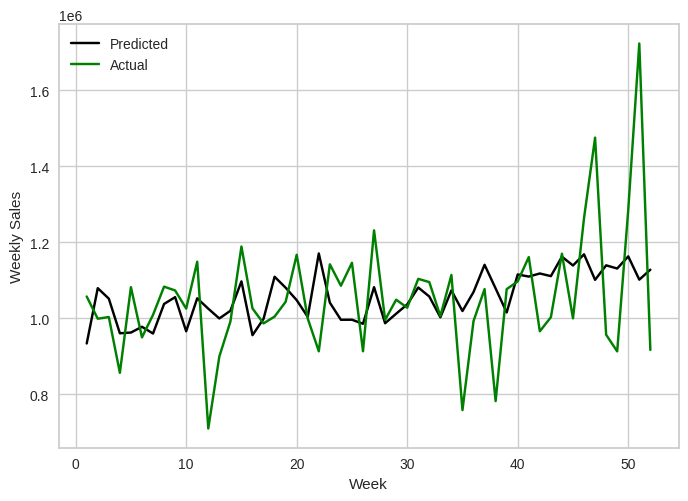

In [103]:
plt.plot(prediction_df.groupby(['Week'])['Predicted'].mean().round(),color='Black',label='Predicted')
plt.plot(prediction_df.groupby(['Week'])['Actual'].mean().round(),color='Green',label='Actual')
plt.xlabel('Week')
plt.ylabel('Weekly Sales')
plt.legend()
plt.show()

In [104]:
print("r2 :",metrics.r2_score(y_test, y_pred))
print("MSLE :",metrics.mean_squared_log_error(y_test, y_pred))
MSE=metrics.mean_squared_error(y_test, y_pred)
print("MSE :", MSE)
import math
RMSE = math.sqrt(MSE)
print("RMSE :", RMSE)

r2 : 0.13930058598951278
MSLE : 0.3336810163549257
MSE : 277278245001.05786
RMSE : 526572.1650458347


In [105]:
# Cross-validation 
scores = cross_val_score(model, x_train, y_train, cv=10, scoring='r2')
print("Cross-Validation Scores:",[scores])
print("Mean R2 Score:", scores.mean()*100,'%')

Cross-Validation Scores: [array([0.13985609, 0.12333826, 0.09942649, 0.13053517, 0.09335412,
       0.12380368, 0.06782889, 0.15297094, 0.13667159, 0.14660978])]
Mean R2 Score: 12.143949831127898 %


In [106]:
#RandomForestRegressor-Model0
x0_train, x0_test, y0_train, y0_test = train_test_split(feature, target, test_size=0.2, random_state=42)
model0 = RandomForestRegressor()        
model0.fit(x0_train,y0_train)

RandomForestRegressor()

In [107]:
y_pred0= model0.predict(x0_test)
y_pred0=pd.DataFrame(y_pred0,columns=["result"]).round()
y_pred0

,result
0,1346384.0
1,1381397.0
2,1819917.0
3,967414.0
4,403611.0
...,...
1282,1485295.0
1283,789443.0
1284,764531.0
1285,1927110.0


In [108]:
prediction_df0 = pd.DataFrame({'Actual0': y0_test.round().values.ravel(), 'Predicted0': y_pred0.round().values.ravel()})
#Filtered
prediction_df0['Month'] = df.loc[x0_test.index, 'Month'].values.ravel()
prediction_df0['Week'] = df.loc[x0_test.index, 'Week'].values.ravel()
prediction_df0


,Actual0,Predicted0,Month,Week
0,1138800.0,1346384.0,12,48
1,1304851.0,1381397.0,6,25
2,1769296.0,1819917.0,10,43
3,1077640.0,967414.0,11,45
4,428852.0,403611.0,3,11
...,...,...,...,...
1282,1492061.0,1485295.0,6,23
1283,801098.0,789443.0,5,21
1284,890690.0,764531.0,5,17
1285,2066188.0,1927110.0,2,5


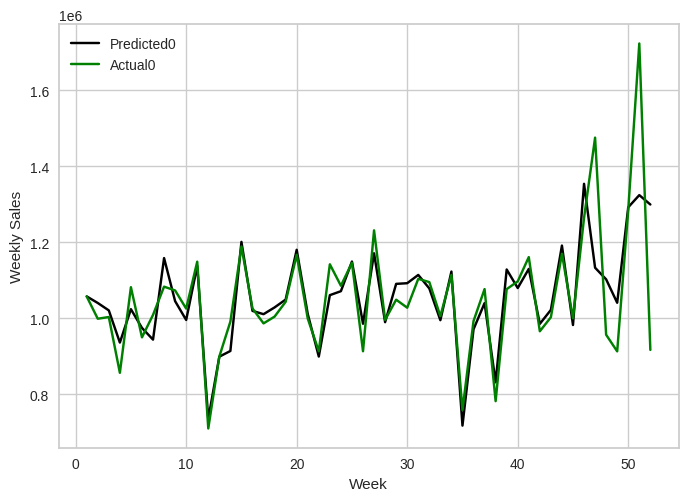

In [109]:
plt.plot(prediction_df0.groupby(['Week'])['Predicted0'].mean().round(),color='Black',label='Predicted0')
plt.plot(prediction_df0.groupby(['Week'])['Actual0'].mean().round(),color='Green',label='Actual0')
plt.xlabel('Week')
plt.ylabel('Weekly Sales')
plt.legend()
plt.show()

In [110]:
print("r2 :",metrics.r2_score(y0_test, y_pred0))
print("MSLE :",metrics.mean_squared_log_error(y0_test, y_pred0))
MSE=metrics.mean_squared_error(y0_test, y_pred0)
print("MSE :", MSE)
import math
RMSE = math.sqrt(MSE)
print("RMSE :", RMSE)


r2 : 0.9421557848670229
MSLE : 0.01047162863883162
MSE : 18634777942.744244
RMSE : 136509.2595494688


In [111]:
# Cross-validation 
scores0 = cross_val_score(model0, x0_train, y0_train, cv=10, scoring='r2')
print("Cross-Validation Scores:",[scores0])
print("Mean R2 Score:", scores0.mean()*100,'%')

Cross-Validation Scores: [array([0.94071374, 0.92597516, 0.94632829, 0.9419867 , 0.93735801,
       0.95666416, 0.94641409, 0.93363589, 0.95555625, 0.94821687])]
Mean R2 Score: 94.32849168973911 %


In [112]:
# XGBoost Regression-Model1
x1_train, x1_test, y1_train, y1_test = train_test_split(feature, target, test_size=0.2, random_state=42)
model1 = xgb.XGBRegressor()
model1.fit(x1_train, y1_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [114]:
y_pred1 = model1.predict(x1_test)
y_pred1=pd.DataFrame(y_pred1,columns=["result"]).round()
y_pred1

,result
0,1050585.0
1,1388465.0
2,1840900.0
3,998137.0
4,392651.0
...,...
1282,1448482.0
1283,834742.0
1284,888696.0
1285,1910929.0


In [115]:
prediction_df1 = pd.DataFrame({'Actual1': y1_test.round().values.ravel(), 'Predicted1': y_pred1.round().values.ravel()})
#Filtered
prediction_df1['Month'] = df.loc[x1_test.index, 'Month'].values.ravel()
prediction_df1['Week'] = df.loc[x1_test.index, 'Week'].values.ravel()
prediction_df1


,Actual1,Predicted1,Month,Week
0,1138800.0,1050585.0,12,48
1,1304851.0,1388465.0,6,25
2,1769296.0,1840900.0,10,43
3,1077640.0,998137.0,11,45
4,428852.0,392651.0,3,11
...,...,...,...,...
1282,1492061.0,1448482.0,6,23
1283,801098.0,834742.0,5,21
1284,890690.0,888696.0,5,17
1285,2066188.0,1910929.0,2,5


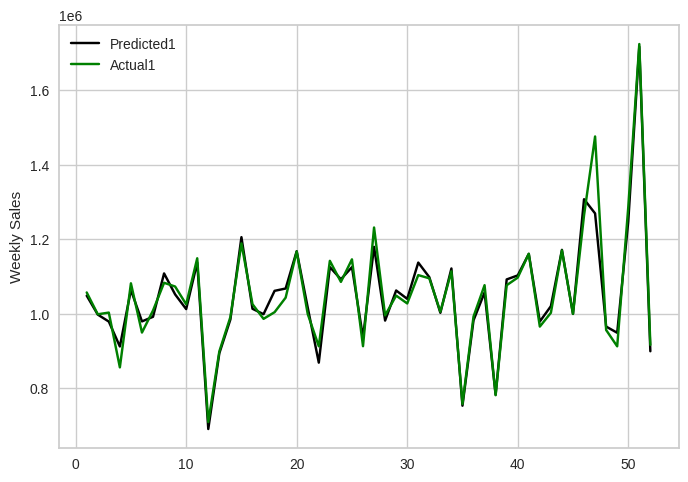

In [116]:
plt.plot(prediction_df1.groupby(['Week'])['Predicted1'].mean().round(),color='Black',label='Predicted1')
plt.plot(prediction_df1.groupby(['Week'])['Actual1'].mean().round(),color='Green',label='Actual1')
plt.ylabel('Weekly Sales')
plt.legend()
plt.show()

In [117]:
print("r2 :",metrics.r2_score(y1_test, y_pred1))
print("MSLE :",metrics.mean_squared_log_error(y1_test, y_pred1))
MSE=metrics.mean_squared_error(y1_test, y_pred1)
print("MSE :", MSE)
import math
RMSE = math.sqrt(MSE)
print("RMSE :", RMSE)

r2 : 0.9722719955700214
MSLE : 0.01232009362002678
MSE : 8932703195.301958
RMSE : 94512.9789780322


In [118]:
# Cross-validation 
scores1 = cross_val_score(model1, x1_train, y1_train, cv=10, scoring='r2')
print("Cross-Validation Scores:",[scores1])
print("Mean R2 Score:", scores1.mean()*100,'%')

Cross-Validation Scores: [array([0.97411748, 0.96835164, 0.97600192, 0.97206036, 0.96577785,
       0.97323579, 0.96942499, 0.9652111 , 0.975262  , 0.9762122 ])]
Mean R2 Score: 97.15655340604789 %
